# Strategie ewolucyjne

Notebook pokazuje podstawowe mechanizmy strategii ewolucyjnych.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

%matplotlib inline

## Przykładowe problemy testowe

In [2]:
# Sphere function (minimum at 0)
def objective_function_F1(X):
    return - np.sum(X**2, axis=1)

# Sphere function - modified
def objective_function_F1a(X):
    return - (X[:, 0]**2 + 9*X[:, 1]**2)

# Sphere function - modified
def objective_function_F1b(X):
    return - (X[:, 0]**2 + 625*X[:, 1]**2)

# Sphere function - modified
def objective_function_F1c(X):
    return - (X[:, 0]**2 + 2*X[:, 1]**2 - 2 * X[:, 0] * X[:, 1])

In [3]:
# Rastrigin function (minimum at 0)
def objective_function_F6(X):
    return - 10.0 * X.shape[1] - np.sum(X**2, axis=1) + 10.0 * np.sum(np.cos(2 * np.pi * X), axis=1)

In [5]:
# Schwefel function (minimum at 420.9687)
# (REMARK: should be considered only on [-500, 500]^d, because there are better minima outside)
def objective_function_F7(X):
    return - 418.9829 * X.shape[1] + np.sum(X * np.sin(np.sqrt(np.abs(X))), axis=1)

In [38]:
# Griewank function (minimum at 0)
def objective_function_F8(X):
    return - 1 - np.sum(X**2 / 4000, axis=1) + np.prod(np.cos(X / np.sqrt(np.linspace(1, X.shape[1], X.shape[1]))), axis=1)

## Przykładowa strategia ewolucyjna

In [4]:
def es(objective_function, chromosome_length, population_size, number_of_iterations, number_of_offspring, number_of_parents, sigma, tau, tau_0, log_frequency=1):

    best_solution = np.empty((1, chromosome_length))
    best_solution_objective_value = 0.00

    log_objective_values = np.empty((number_of_iterations, 4))
    log_best_solutions = np.empty((number_of_iterations, chromosome_length))
    log_best_sigmas = np.empty((number_of_iterations, chromosome_length))

    # generating an initial population
    current_population_solutions = 100.0 * np.random.rand(population_size, chromosome_length)
    current_population_sigmas = sigma * np.ones((population_size, chromosome_length))

    # evaluating the objective function on the current population
    current_population_objective_values = objective_function(current_population_solutions)

    for t in range(number_of_iterations):

        # selecting the parent indices by the roulette wheel method
        fitness_values = current_population_objective_values - current_population_objective_values.min()
        if fitness_values.sum() > 0:
            fitness_values = fitness_values / fitness_values.sum()
        else:
            fitness_values = 1.0 / population_size * np.ones(population_size)
        parent_indices = np.random.choice(population_size, (number_of_offspring, number_of_parents), True, fitness_values).astype(np.int64)

        # creating the children population by Global Intermediere Recombination
        children_population_solutions = np.zeros((number_of_offspring, chromosome_length))
        children_population_sigmas = np.zeros((number_of_offspring, chromosome_length))
        for i in range(number_of_offspring):
            children_population_solutions[i, :] = current_population_solutions[parent_indices[i, :], :].mean(axis=0)
            children_population_sigmas[i, :] = current_population_sigmas[parent_indices[i, :], :].mean(axis=0)

        # mutating the children population by adding random gaussian noise
        children_population_sigmas = children_population_sigmas * np.exp(tau * np.random.randn(number_of_offspring, chromosome_length) + tau_0 * np.random.randn(number_of_offspring, 1))
        children_population_solutions = children_population_solutions + children_population_sigmas * np.random.randn(number_of_offspring, chromosome_length)

        # evaluating the objective function on the children population
        children_population_objective_values = objective_function(children_population_solutions)

        # replacing the current population by (Mu + Lambda) Replacement
        current_population_objective_values = np.hstack([current_population_objective_values, children_population_objective_values])
        current_population_solutions = np.vstack([current_population_solutions, children_population_solutions])
        current_population_sigmas = np.vstack([current_population_sigmas, children_population_sigmas])

        I = np.argsort(current_population_objective_values)[::-1]
        current_population_solutions = current_population_solutions[I[:population_size], :]
        current_population_sigmas = current_population_sigmas[I[:population_size], :]
        current_population_objective_values = current_population_objective_values[I[:population_size]]

        # recording some statistics
        if best_solution_objective_value < current_population_objective_values[0]:
            best_solution = current_population_solutions[0, :]
            best_solution_objective_value = current_population_objective_values[0]
        log_objective_values[t, :] = [current_population_objective_values.min(), current_population_objective_values.max(), current_population_objective_values.mean(), current_population_objective_values.std()]
        log_best_solutions[t, :] = current_population_solutions[0, :]
        log_best_sigmas[t, :] = current_population_sigmas[0, :]

        if np.mod(t, log_frequency) == 0:
            print("Iteration %04d : best score = %0.8f, mean score = %0.8f." % (t, log_objective_values[:t+1, 1].max(), log_objective_values[t, 2]))

    return best_solution_objective_value, best_solution, log_objective_values, log_best_solutions, log_best_sigmas

### Działanie strategii ewolucyjnej dla funkcji sferycznej F1

Iteration 0000 : best score = -7491.64853117, mean score = -26007.57043230.
Iteration 0010 : best score = -50.73895808, mean score = -232.38558350.
Iteration 0020 : best score = -0.08865024, mean score = -0.58599934.
Iteration 0030 : best score = -0.00020930, mean score = -0.00121897.
Iteration 0040 : best score = -0.00000037, mean score = -0.00000317.
Iteration 0050 : best score = -0.00000000, mean score = -0.00000001.
Iteration 0060 : best score = -0.00000000, mean score = -0.00000000.
Iteration 0070 : best score = -0.00000000, mean score = -0.00000000.


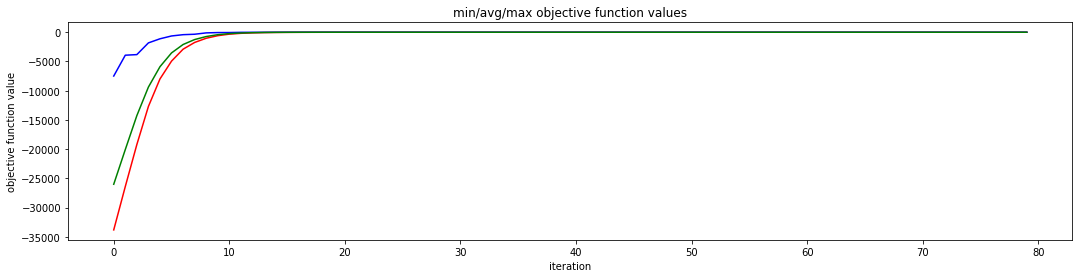

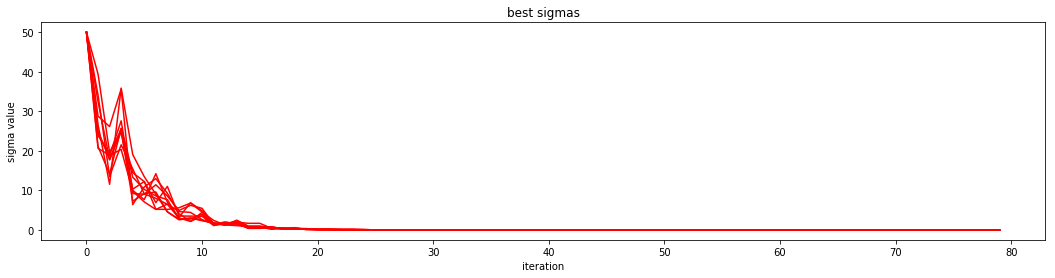

In [17]:
d = 10
N = 2000
T = 80

best_objective_value, best_chromosome, history_objective_values, history_best_chromosome, history_best_sigmas = es(
    objective_function_F1, d, N, T, 2*N, 2, 50.0, 1/np.sqrt(2*d), 1/np.sqrt(2*np.sqrt(d)), 10)

plt.figure(figsize=(18, 4))
plt.plot(history_objective_values[:, 0], 'r-')
plt.plot(history_objective_values[:, 1], 'b-')
plt.plot(history_objective_values[:, 2], 'g-')
plt.xlabel('iteration')
plt.ylabel('objective function value')
plt.title('min/avg/max objective function values')
plt.show()

plt.figure(figsize=(18, 4))
plt.plot(history_best_sigmas, 'r-')
plt.xlabel('iteration')
plt.ylabel('sigma value')
plt.title('best sigmas')
plt.show()

Iteration 0000 : best score = -29698.59315987, mean score = -59367.84185988.
Iteration 0010 : best score = -977.43360298, mean score = -2097.26655573.
Iteration 0020 : best score = -21.45931141, mean score = -53.22461810.
Iteration 0030 : best score = -0.67579603, mean score = -1.48867507.
Iteration 0040 : best score = -0.01668080, mean score = -0.04334739.
Iteration 0050 : best score = -0.00050458, mean score = -0.00117247.
Iteration 0060 : best score = -0.00001395, mean score = -0.00002896.
Iteration 0070 : best score = -0.00000027, mean score = -0.00000068.
Iteration 0080 : best score = -0.00000001, mean score = -0.00000002.
Iteration 0090 : best score = -0.00000000, mean score = -0.00000000.


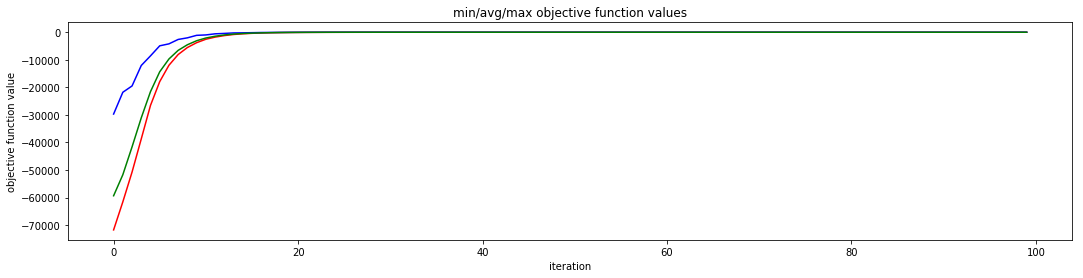

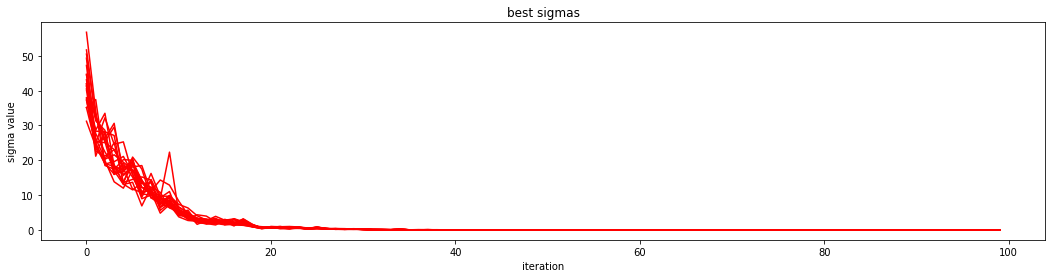

In [20]:
d = 20
N = 1000
T = 100

best_objective_value, best_chromosome, history_objective_values, history_best_chromosome, history_best_sigmas = es(
    objective_function_F1, d, N, T, 2*N, 2, 50.0, 1/np.sqrt(2*d), 1/np.sqrt(2*np.sqrt(d)), 10)

plt.figure(figsize=(18, 4))
plt.plot(history_objective_values[:, 0], 'r-')
plt.plot(history_objective_values[:, 1], 'b-')
plt.plot(history_objective_values[:, 2], 'g-')
plt.xlabel('iteration')
plt.ylabel('objective function value')
plt.title('min/avg/max objective function values')
plt.show()

plt.figure(figsize=(18, 4))
plt.plot(history_best_sigmas, 'r-')
plt.xlabel('iteration')
plt.ylabel('sigma value')
plt.title('best sigmas')
plt.show()

Iteration 0000 : best score = -240589.27620168, mean score = -316807.91678957.
Iteration 0010 : best score = -82978.11133346, mean score = -93558.19009680.
Iteration 0020 : best score = -36462.00516560, mean score = -41089.98574134.
Iteration 0030 : best score = -16075.06779099, mean score = -17963.12917407.
Iteration 0040 : best score = -7151.22418313, mean score = -8113.30059753.
Iteration 0050 : best score = -3023.04845695, mean score = -3727.65956723.
Iteration 0060 : best score = -1480.66632627, mean score = -1727.24628451.
Iteration 0070 : best score = -712.20315532, mean score = -816.84249617.
Iteration 0080 : best score = -358.43468319, mean score = -406.24110065.
Iteration 0090 : best score = -193.28350006, mean score = -211.40350531.
Iteration 0100 : best score = -97.01423277, mean score = -110.32800830.
Iteration 0110 : best score = -53.60434632, mean score = -58.69179959.
Iteration 0120 : best score = -27.39701955, mean score = -30.81186674.
Iteration 0130 : best score = -1

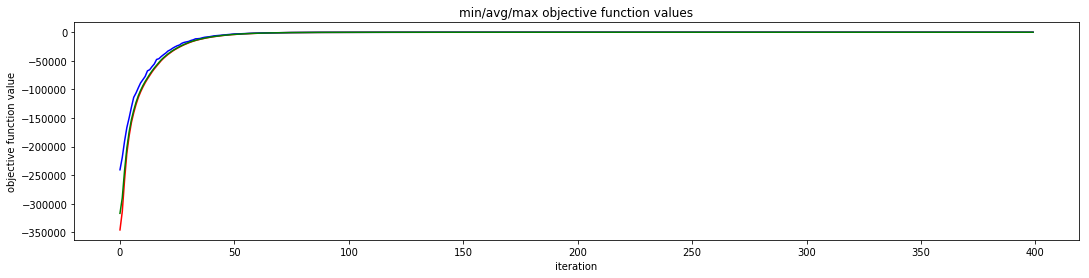

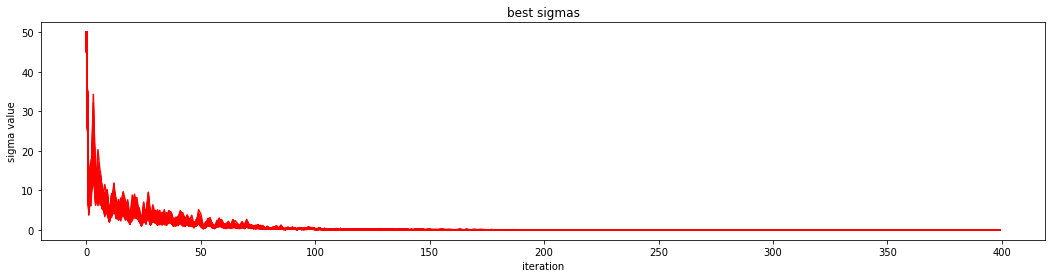

In [43]:
d = 100
N = 2000
T = 400

best_objective_value, best_chromosome, history_objective_values, history_best_chromosome, history_best_sigmas = es(
    objective_function_F1, d, N, T, 4*N, 2, 50.0, 2/np.sqrt(2*d), 2/np.sqrt(2*np.sqrt(d)), 10)

plt.figure(figsize=(18, 4))
plt.plot(history_objective_values[:, 0], 'r-')
plt.plot(history_objective_values[:, 1], 'b-')
plt.plot(history_objective_values[:, 2], 'g-')
plt.xlabel('iteration')
plt.ylabel('objective function value')
plt.title('min/avg/max objective function values')
plt.show()

plt.figure(figsize=(18, 4))
plt.plot(history_best_sigmas, 'r-')
plt.xlabel('iteration')
plt.ylabel('sigma value')
plt.title('best sigmas')
plt.show()

### Działanie strategii ewolucyjnej dla funkcji Rastrigina F6

Iteration 0000 : best score = -7926.73967326, mean score = -28640.32714334.
Iteration 0010 : best score = -51.25766368, mean score = -101.92889441.
Iteration 0020 : best score = -23.55843930, mean score = -56.09934053.
Iteration 0030 : best score = -16.20878541, mean score = -46.30688817.
Iteration 0040 : best score = -0.00413263, mean score = -0.02821344.
Iteration 0050 : best score = -0.00000041, mean score = -0.00000331.
Iteration 0060 : best score = -0.00000000, mean score = -0.00000000.
Iteration 0070 : best score = 0.00000000, mean score = -0.00000000.
Iteration 0080 : best score = 0.00000000, mean score = 0.00000000.
Iteration 0090 : best score = 0.00000000, mean score = 0.00000000.
Iteration 0100 : best score = 0.00000000, mean score = 0.00000000.
Iteration 0110 : best score = 0.00000000, mean score = 0.00000000.
Iteration 0120 : best score = 0.00000000, mean score = 0.00000000.
Iteration 0130 : best score = 0.00000000, mean score = 0.00000000.
Iteration 0140 : best score = 0.0

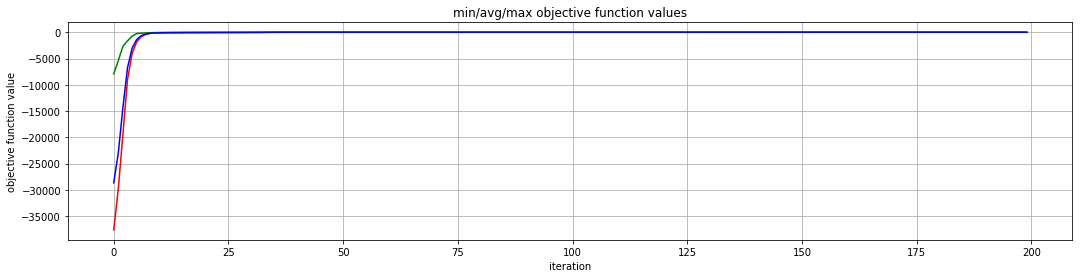

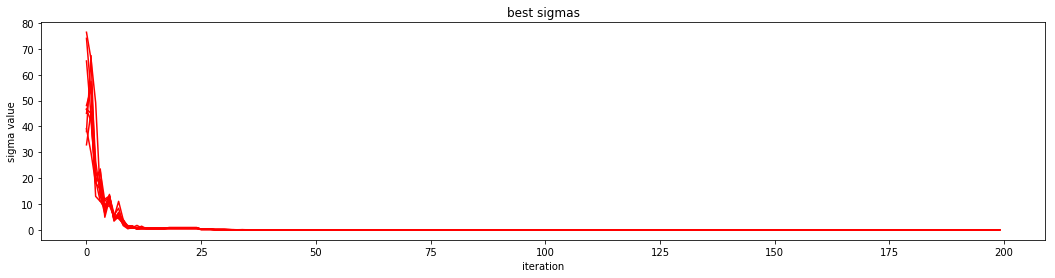

In [34]:
d = 10
N = 2000
T = 200

best_objective_value, best_chromosome, history_objective_values, history_best_chromosome, history_best_sigmas = es(
    objective_function_F6, d, N, T, 6*N, 2, 100.0, 1/np.sqrt(2*d), 1/np.sqrt(2*np.sqrt(d)), 10)

plt.figure(figsize=(18, 4))
plt.plot(history_objective_values[:, 0], 'r-')
plt.plot(history_objective_values[:, 1], 'g-')
plt.plot(history_objective_values[:, 2], 'b-')
plt.grid()
plt.xlabel('iteration')
plt.ylabel('objective function value')
plt.title('min/avg/max objective function values')
plt.show()

plt.figure(figsize=(18, 4))
plt.plot(history_best_sigmas, 'r-')
plt.xlabel('iteration')
plt.ylabel('sigma value')
plt.title('best sigmas')
plt.show()

Iteration 0000 : best score = -21909.48329742, mean score = -64816.97206845.
Iteration 0010 : best score = -1187.06914503, mean score = -2053.41693541.
Iteration 0020 : best score = -149.73369338, mean score = -232.33841733.
Iteration 0030 : best score = -113.41173652, mean score = -177.12140477.
Iteration 0040 : best score = -96.49254054, mean score = -160.28332567.
Iteration 0050 : best score = -38.61441086, mean score = -46.05047212.
Iteration 0060 : best score = -31.88284778, mean score = -31.92698597.
Iteration 0070 : best score = -31.83927796, mean score = -31.83996850.
Iteration 0080 : best score = -31.83868496, mean score = -31.83869841.
Iteration 0090 : best score = -31.83866989, mean score = -31.83867009.
Iteration 0100 : best score = -31.83866968, mean score = -31.83866968.
Iteration 0110 : best score = -31.83866968, mean score = -31.83866968.
Iteration 0120 : best score = -31.83866968, mean score = -31.83866968.
Iteration 0130 : best score = -31.83866968, mean score = -31.8

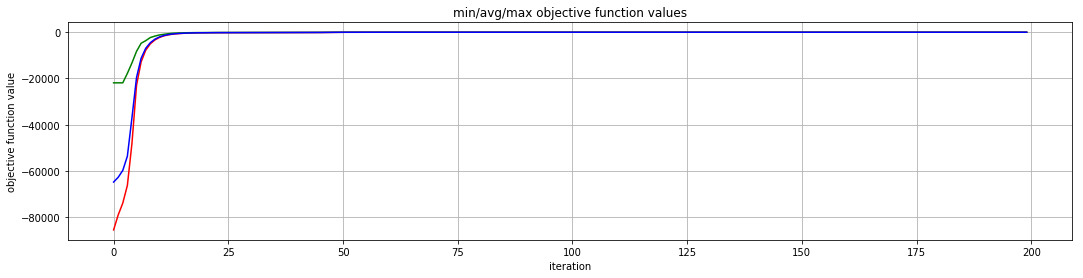

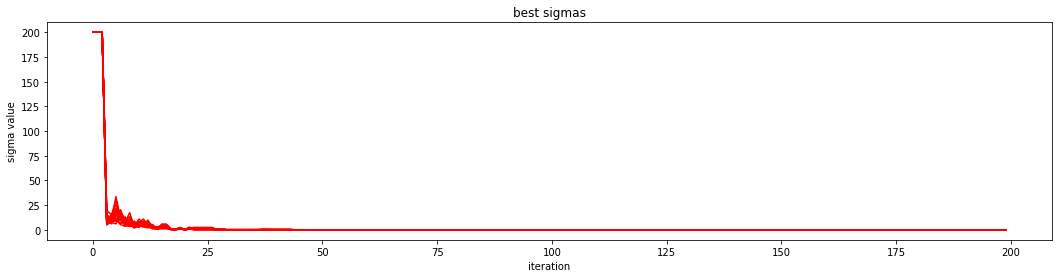

In [57]:
d = 20
N = 4000
T = 200

best_objective_value, best_chromosome, history_objective_values, history_best_chromosome, history_best_sigmas = es(
    objective_function_F6, d, N, T, 6*N, 3, 200.0, 2/np.sqrt(2*d), 2/np.sqrt(2*np.sqrt(d)), 10)

plt.figure(figsize=(18, 4))
plt.plot(history_objective_values[:, 0], 'r-')
plt.plot(history_objective_values[:, 1], 'g-')
plt.plot(history_objective_values[:, 2], 'b-')
plt.grid()
plt.xlabel('iteration')
plt.ylabel('objective function value')
plt.title('min/avg/max objective function values')
plt.show()

plt.figure(figsize=(18, 4))
plt.plot(history_best_sigmas, 'r-')
plt.xlabel('iteration')
plt.ylabel('sigma value')
plt.title('best sigmas')
plt.show()

Iteration 0000 : best score = -229461.48115213, mean score = -334880.00681549.
Iteration 0010 : best score = -229461.48115213, mean score = -334659.63716372.
Iteration 0020 : best score = -229461.48115213, mean score = -334441.93394004.
Iteration 0030 : best score = -229461.48115213, mean score = -334208.77148951.
Iteration 0040 : best score = -229461.48115213, mean score = -333798.60668904.
Iteration 0050 : best score = -229461.48115213, mean score = -332769.52983794.
Iteration 0060 : best score = -164285.13798590, mean score = -204535.04922414.
Iteration 0070 : best score = -65881.96589178, mean score = -75440.51939081.
Iteration 0080 : best score = -27281.71450205, mean score = -31768.06530557.
Iteration 0090 : best score = -12493.17180983, mean score = -14114.53499031.
Iteration 0100 : best score = -5753.41925299, mean score = -6835.88964123.
Iteration 0110 : best score = -3166.68203078, mean score = -3592.57453347.
Iteration 0120 : best score = -2058.03814481, mean score = -2407.4

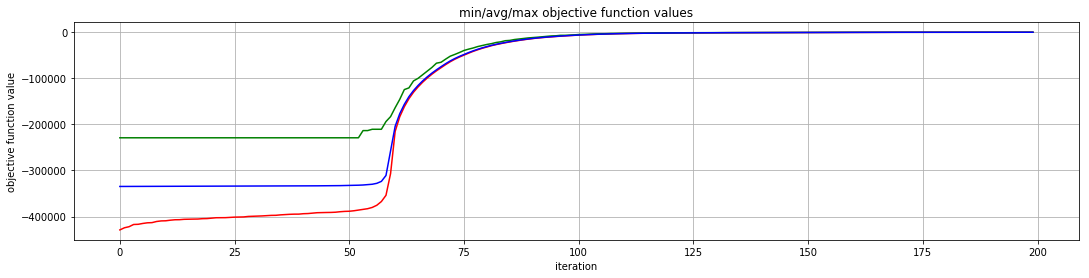

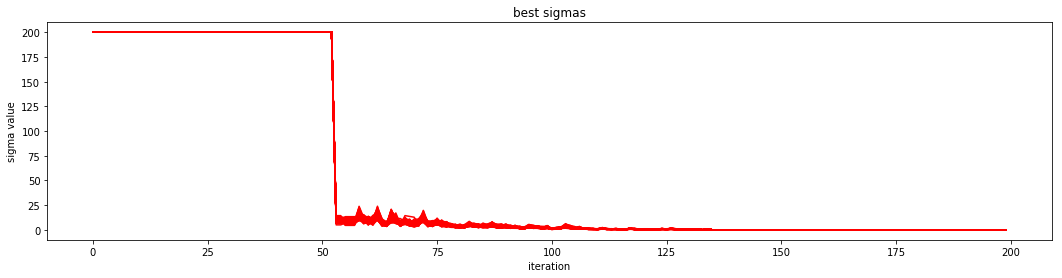

In [58]:
d = 100
N = 4000
T = 200

best_objective_value, best_chromosome, history_objective_values, history_best_chromosome, history_best_sigmas = es(
    objective_function_F6, d, N, T, 4*N, 2, 200.0, 2/np.sqrt(2*d), 2/np.sqrt(2*np.sqrt(d)), 10)

plt.figure(figsize=(18, 4))
plt.plot(history_objective_values[:, 0], 'r-')
plt.plot(history_objective_values[:, 1], 'g-')
plt.plot(history_objective_values[:, 2], 'b-')
plt.grid()
plt.xlabel('iteration')
plt.ylabel('objective function value')
plt.title('min/avg/max objective function values')
plt.show()

plt.figure(figsize=(18, 4))
plt.plot(history_best_sigmas, 'r-')
plt.xlabel('iteration')
plt.ylabel('sigma value')
plt.title('best sigmas')
plt.show()

### Działanie strategii ewolucyjnej dla funkcji Griewanka F8

Iteration 0000 : best score = -8.89942517, mean score = -16.18765076.
Iteration 0010 : best score = -1.17363408, mean score = -1.38152314.
Iteration 0020 : best score = -0.62426303, mean score = -0.94315512.
Iteration 0030 : best score = -0.06723438, mean score = -0.13881099.
Iteration 0040 : best score = -0.00402960, mean score = -0.00790405.
Iteration 0050 : best score = -0.00010856, mean score = -0.00021223.
Iteration 0060 : best score = -0.00000329, mean score = -0.00000591.
Iteration 0070 : best score = -0.00000007, mean score = -0.00000014.
Iteration 0080 : best score = -0.00000000, mean score = -0.00000000.
Iteration 0090 : best score = -0.00000000, mean score = -0.00000000.


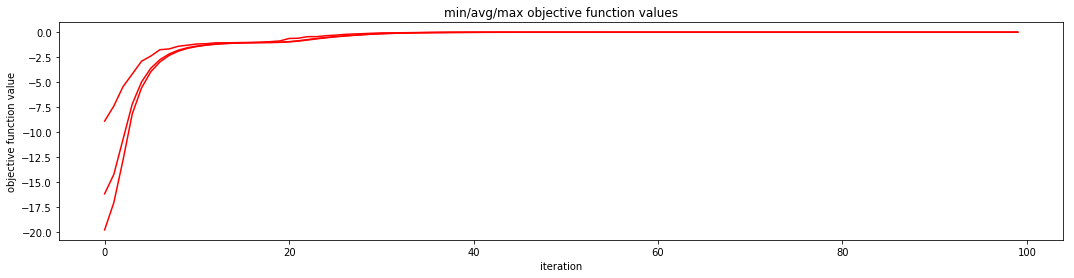

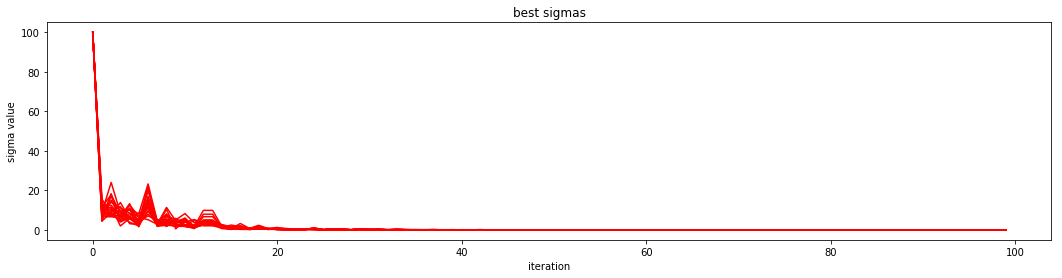

In [59]:
d = 20
N = 2000
T = 100

best_objective_value, best_chromosome, history_objective_values, history_best_chromosome, history_best_sigmas = es(
    objective_function_F8, d, N, T, 4*N, 2, 100.0, 2/np.sqrt(2*d), 2/np.sqrt(2*np.sqrt(d)), 10)

plt.figure(figsize=(18, 4))
plt.plot(history_objective_values[:, 0], 'r-')
plt.plot(history_objective_values[:, 1], 'r-')
plt.plot(history_objective_values[:, 2], 'r-')
plt.xlabel('iteration')
plt.ylabel('objective function value')
plt.title('min/avg/max objective function values')
plt.show()

plt.figure(figsize=(18, 4))
plt.plot(history_best_sigmas, 'r-')
plt.xlabel('iteration')
plt.ylabel('sigma value')
plt.title('best sigmas')
plt.show()

Iteration 0000 : best score = -22.22277436, mean score = -38.87239490.
Iteration 0010 : best score = -4.93877386, mean score = -6.64097544.
Iteration 0020 : best score = -1.82117804, mean score = -2.12336510.
Iteration 0030 : best score = -1.19565194, mean score = -1.23627464.
Iteration 0040 : best score = -1.03523605, mean score = -1.05083416.
Iteration 0050 : best score = -0.67283814, mean score = -0.75775559.
Iteration 0060 : best score = -0.36430785, mean score = -0.40730066.
Iteration 0070 : best score = -0.17998838, mean score = -0.20699331.
Iteration 0080 : best score = -0.07897112, mean score = -0.09771513.
Iteration 0090 : best score = -0.03780395, mean score = -0.04312159.
Iteration 0100 : best score = -0.01622528, mean score = -0.01924512.
Iteration 0110 : best score = -0.01176910, mean score = -0.01243366.
Iteration 0120 : best score = -0.00892268, mean score = -0.00923419.
Iteration 0130 : best score = -0.00787244, mean score = -0.00798778.
Iteration 0140 : best score = -0

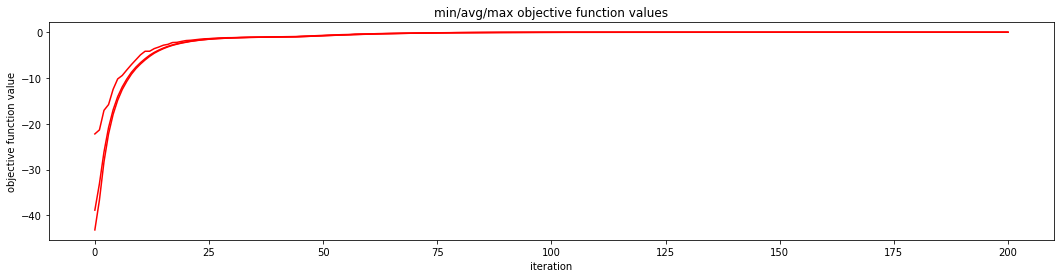

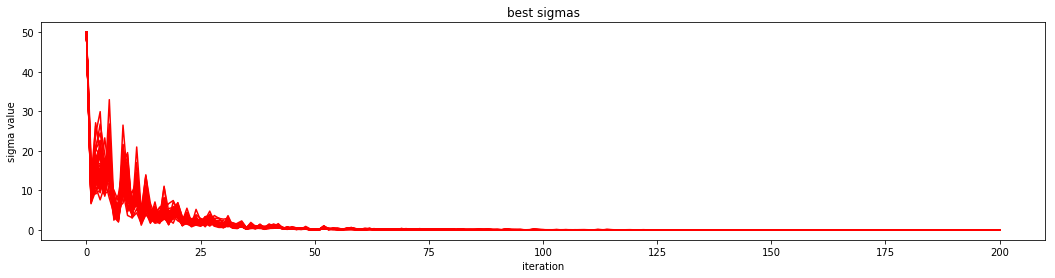

In [40]:
d = 50
N = 2000
T = 201

best_objective_value, best_chromosome, history_objective_values, history_best_chromosome, history_best_sigmas = es(
    objective_function_F8, d, N, T, 4*N, 2, 50.0, 2/np.sqrt(2*d), 2/np.sqrt(2*np.sqrt(d)), 10)

plt.figure(figsize=(18, 4))
plt.plot(history_objective_values[:, 0], 'r-')
plt.plot(history_objective_values[:, 1], 'r-')
plt.plot(history_objective_values[:, 2], 'r-')
plt.xlabel('iteration')
plt.ylabel('objective function value')
plt.title('min/avg/max objective function values')
plt.show()

plt.figure(figsize=(18, 4))
plt.plot(history_best_sigmas, 'r-')
plt.xlabel('iteration')
plt.ylabel('sigma value')
plt.title('best sigmas')
plt.show()

Iteration 0000 : best score = -57.58171418, mean score = -84.23303822.
Iteration 0010 : best score = -57.58171418, mean score = -84.18923494.
Iteration 0020 : best score = -57.58171418, mean score = -84.15379124.
Iteration 0030 : best score = -57.58171418, mean score = -84.11735062.
Iteration 0040 : best score = -57.58171418, mean score = -84.11179914.
Iteration 0050 : best score = -57.58171418, mean score = -84.09071506.
Iteration 0060 : best score = -57.58171418, mean score = -84.06378525.
Iteration 0070 : best score = -57.58171418, mean score = -84.01139180.
Iteration 0080 : best score = -57.58171418, mean score = -83.97758654.
Iteration 0090 : best score = -57.58171418, mean score = -83.87156621.
Iteration 0100 : best score = -57.58171418, mean score = -83.70033794.
Iteration 0110 : best score = -57.58171418, mean score = -83.35389991.
Iteration 0120 : best score = -38.57264007, mean score = -46.73901025.
Iteration 0130 : best score = -19.73321288, mean score = -22.70340724.
Iterat

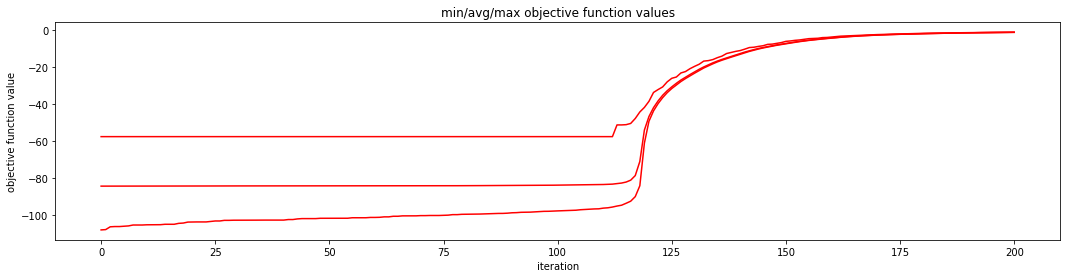

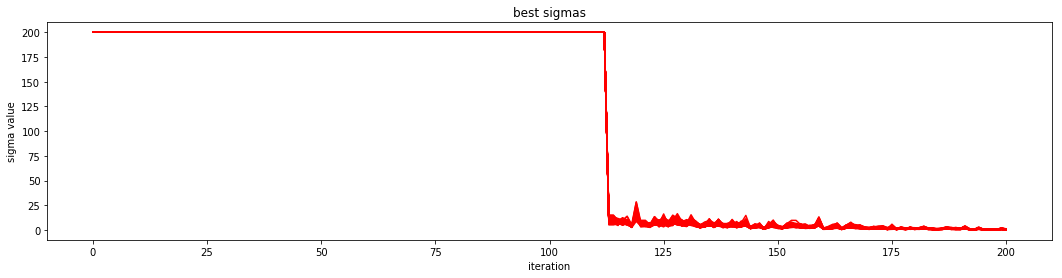

In [60]:
d = 100
N = 2000
T = 201

best_objective_value, best_chromosome, history_objective_values, history_best_chromosome, history_best_sigmas = es(
    objective_function_F8, d, N, T, 2*N, 2, 200.0, 2/np.sqrt(2*d), 2/np.sqrt(2*np.sqrt(d)), 10)

plt.figure(figsize=(18, 4))
plt.plot(history_objective_values[:, 0], 'r-')
plt.plot(history_objective_values[:, 1], 'r-')
plt.plot(history_objective_values[:, 2], 'r-')
plt.xlabel('iteration')
plt.ylabel('objective function value')
plt.title('min/avg/max objective function values')
plt.show()

plt.figure(figsize=(18, 4))
plt.plot(history_best_sigmas, 'r-')
plt.xlabel('iteration')
plt.ylabel('sigma value')
plt.title('best sigmas')
plt.show()